# Creating Autonomous Agent to Play Pacman with Deep Q-Learning

## (DEMO) Demonstrating live pacman game-play with optimial trained model
Play game with trained Q-net to demonstrate how it works. Use previously training weights for this demo.
<br>
*Note: This game updates very slowly on jupyter notebook. It works much better if run on local computer.*

In [1]:
!pip install "gymnasium[atari, accept-rom-license]"
import ale_py

In [9]:
from qNetArchitecture import MsPacmanGame, DQN_3HL, DQN_2HL, DQN_4HL
import random
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import torch

Game ended with score:  1690.0


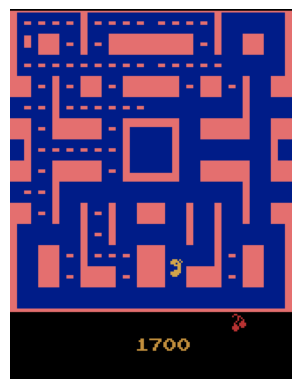

In [10]:
# initalize previously trained game
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weightsFile = 'Best_QNET_policy_net_weights_200epochs.pth'
pacmanGame = MsPacmanGame(DQN = DQN_3HL, N_nodes=24, device=device, weightsFile = weightsFile)

score, _,_,_,_ = pacmanGame.play(plotInline=True)

print("Game ended with score: ", score)

Based on the paper '*Playing Atari with Deep Reinforcement Learning*' by Mnih et al, 2013

### Index:
- Part 1) Training the Q-net on various hyperparameters to optimize model
- Part 2) Training the optimal version of the Q-net for many epochs

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1) Training the Q-net on various hyperparameters to optimize model
Since in this unsupervised reinforment learning situation, there is no ground truth so we must evaluate the best playing method in other ways.
<br>
To evaluate how well the game is played, *Ngames* test games will be played without training. The average game score will give insight into how successful the agent is.


In [4]:
# play game 5 times to determine average score
def testGames(pacmanGame, Ngames = 5):
  scoreAll = []
  durAll = []
  rewardsAll = []
  QAll = []

  for i in range(Ngames):
      score, _, dur, reward, Q = pacmanGame.play(show=0)
      print("Game ended with score: ", score)
      scoreAll.append(score)
      durAll.append(dur)
      rewardsAll.append(reward)
      QAll.append(Q)

  #averageScore = sum(scoreAll)/Ngames
  return scoreAll, durAll, rewardsAll, QAll

The Q-network architechture is defined in qNetArchitecture.py.
<br>
It takes the state vector as input, which is a 1 X 24 vector ---> layer 1 (24 nodes) ----> layer 2 (24 nodes) ----> layer 3 (24 nodes) ----> output (1 X 9 Q-value vector for each action).
<br>
There is also another option to use a 2 layer version of this Q-net.

In [5]:
## USER DEFINED PARAMETERS:
# Name your model:
name = "QNET_3HL"
# choose a seed for your game:
#seedSet = 42
seedSet = random.randint(0, 100)
# will you be training or just playing?:

# type of nn for Q evaluation:
#DQN = DQN_2HL
DQN = DQN_3HL

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

All tests will be trained for a small number of epochs

In [6]:
# number for epochs for hyperparameter tuning
Nepochs = 20

Creating a function to test different models and get evaluation metrics for their performance.
<br>
To evaluate the model, following will be used:
- The game's scores along various training episodes
    - higher scores would indicate better game success
- The Q-net's training error given by the Q-learning algorithm: *Q(s_t, a) - [GAMMA*Q(s_{t+1}) + R ]*
    - lower error means the Q-net is learning from it's environment
- The training game's duration (number of moves)
    - longer games means agent is avoiding being eaten by ghosts
- The reward obtained throughing training epochs
    - larger rewards indicate agent is acting to maximize coins eaten while staying away from ghosts
- Average Q value of Q-maximizing action
    - larger average Q means an optimal path is being learned and for selected

<b>
The reward and average maximizing Q-value per epoch were also used to evaluate Q-net models in the paper '*Playing Atari with Deep Reinforcement Learning*' by Mnih et al, 2013

In [7]:
def testModels(Nepochs=5, QNet=DQN_3HL, Nnodes=24, ghostReward=True, explore="greedy", gamma=0.5, eps_start=0.9, eps_end=0.1, eps_decay=2500, tau=0.01, lr=0.0001, ucb=4, save=False, name=''):
    # train games
    trainScores = [] # the number of game points aquired at each training step
    trainErrors = [] # error used to train the Q-net --> Q(s_t, a) - [GAMMA*Q(s_{t+1}) + R ]
    trainDur = [] # duration of each game play before all 3 lives are lost and the game is terminated
    trainRewards = [] #
    trainQs = []

    testDur = []
    testScores = []
    testRewards = []
    testQs = []

    # make all hyperparameters a list if they aren't already. This way we can itterate through them for different hyperparameter tuning
    parameters = [QNet, Nnodes, explore, ghostReward, gamma, eps_start, eps_end, eps_decay, tau, lr, ucb, name]

    # how many models need to be tested
    Ngames = [len(p) if isinstance(p, list) else 1 for p in parameters]
    Ngames = max(Ngames)
    print('Testing ' + str(Ngames) + ' models')

    parameters = [[parameter]*Ngames if not(isinstance(parameter,list)) else parameter for parameter in parameters]
    QNet, Nnodes, explore, ghostReward, gamma, eps_start, eps_end, eps_decay, tau, lr, ucb, name = parameters

    for i in range(Ngames):
        # initalize new game
        pacmanGame = MsPacmanGame(DQN = QNet[i], N_nodes = Nnodes[i], device=device)

        #avrgReward, avrgQ
        print(f"eps_end is {eps_end[i]}")
        scoreAll, errorGame, gameDur, rewardsAll, QsAll = pacmanGame.train(actionSelected = explore[i], GhostReward=ghostReward[i], epochs=Nepochs, gamma=gamma[i], \
                                                                           eps_start=eps_start[i], eps_end=eps_end[i], eps_decay=eps_decay[i], \
                                                                           tau=tau[i], lr=lr[i], ucb = ucb[i], show=0, save = save, saveName=name[i])
        trainScores.append(scoreAll)
        trainErrors.append(errorGame)
        trainDur.append(gameDur)
        trainRewards.append(rewardsAll)
        trainQs.append(QsAll)

        # test how this model works
        scores, dur, rewards, Qs = testGames(pacmanGame, Ngames=7)
        testScores.append(scores)
        testDur.append(dur)
        testRewards.append(rewards)
        testQs.append(Qs)

    return trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs

In [8]:
def plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=False):

    metrics = [trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, [], testDur, testRewards, testQs]
    ylabels = ["scores","error","steps","avrg reward","Q-value","scores", None, "steps","avrg reward", "Q-value"]
    titles = ["Training Game's Scores", "Training Game's Error", "Training Games' Durations", "Training Games' Average Rewards", "Training Games' Average Q's", "Test Games' Scores", None,"Test Games' Durations", "Test Games' Average Rewards", "Test Games' Average Q's"]

    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    axs = axs.flatten()

    for j in range(len(metrics)):
        # plot training scores
        metric = metrics[j]
        ax = axs[j]
        for i in range(len(metric)):
            if labels != False:
                ax.plot(metric[i], label=labels[i])
            else:
                ax.plot(metric[i])
        ax.set_xlabel("epochs")
        ax.set_ylabel(ylabels[j])
        ax.set_title(titles[j])
        if labels != False: # include legend for labels
            ax.legend(loc=2)

    plt.tight_layout()
    plt.show()

Evaluating the 2, 3 and 4 hidden layers Q-net achitechture.

Testing 3 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_2HL'> with 24 nodes, with policy net 135054844090192 , and 135054879916560. lr = 0.0001, gamma = 0.5, tau = 0.01. Action = <bound method MsPacmanGame.select_action_Greedy of <qNetArchitecture.MsPacmanGame object at 0x7ad4e7fdc6d0>>. Memory address for model is 135054885271504
episode:  0
Complete with score:  170.0
episode:  1
Complete with score:  510.0
episode:  2
Complete with score:  590.0
episode:  3
Complete with score:  760.0
episode:  4
Complete with score:  170.0
episode:  5
Complete with score:  180.0
episode:  6
Complete with score:  220.0
episode:  7
Complete with score:  170.0
episode:  8
Complete with score:  230.0
episode:  9
Complete with score:  80.0
episode:  10
Complete with score:  290.0
episode:  11
Complete with score:  260.0
episode:  12
Complete with score:  670.0
episode:  13
Complete with score:  250.0
episode:  14
Complete with score:  620.0
episode:  15
Complete with score:  120.0

<ipython-input-24-a998bc29578d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=2)


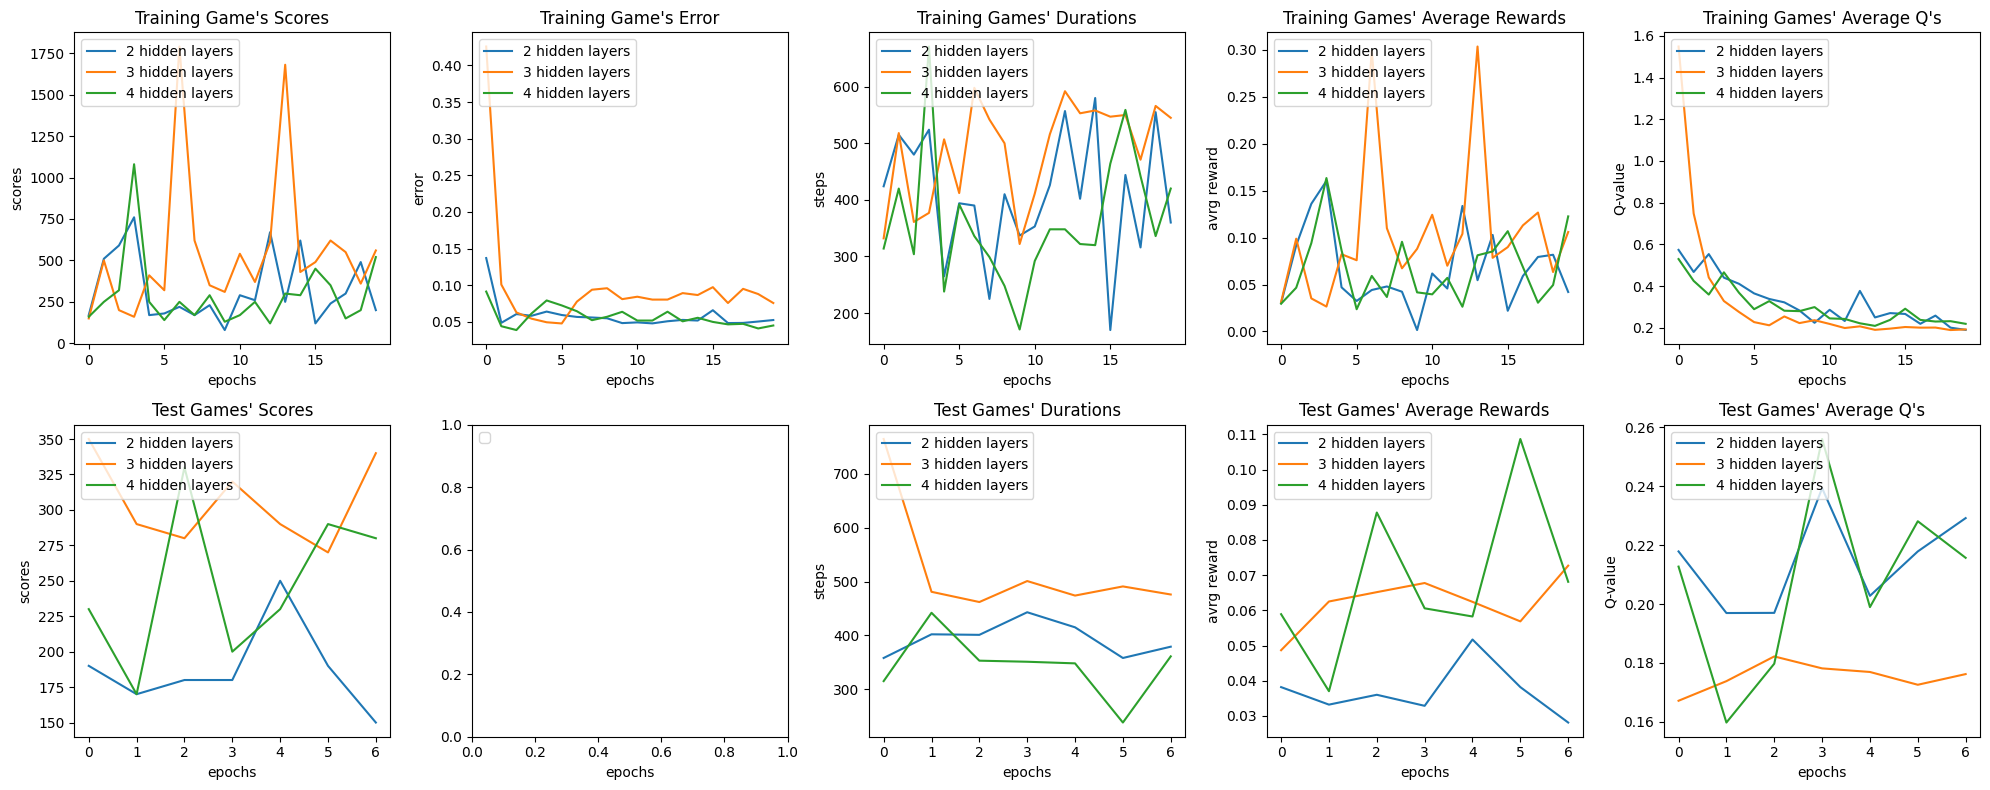

In [ ]:
# initalize new game ( 2 hidden layers)
QNets = [DQN_2HL, DQN_3HL, DQN_4HL]
names = ["2 hidden layers", "3 hidden layers", "4 hidden layers"]

trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(Nepochs = Nepochs, QNet = QNets)

plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=names)

Pick Best model

In [ ]:
# average test scores
testScores = [sum(score)/len(score) for score in testScores]
Qnet_Best = QNets[np.argmax(testScores)]
print(" Best Q-net was : "+str(Qnet_Best))

 Best Q-net was : <class 'qNetArchitecture.DQN_3HL'>


Evaluating the optimal number of nodes at the hidden layers.

Testing 3 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_3HL'> with 15 nodes, with policy net 135054878602704 , and 135054835477840. lr = 0.0001, gamma = 0.5, tau = 0.01. Action = <bound method MsPacmanGame.select_action_Greedy of <qNetArchitecture.MsPacmanGame object at 0x7ad4e8080390>>. Memory address for model is 135054880681424
episode:  0
Complete with score:  270.0
episode:  1
Complete with score:  260.0
episode:  2
Complete with score:  210.0
episode:  3
Complete with score:  340.0
episode:  4
Complete with score:  290.0
episode:  5
Complete with score:  220.0
episode:  6
Complete with score:  240.0
episode:  7
Complete with score:  280.0
episode:  8
Complete with score:  220.0
episode:  9
Complete with score:  230.0
episode:  10
Complete with score:  270.0
episode:  11
Complete with score:  200.0
episode:  12
Complete with score:  380.0
episode:  13
Complete with score:  160.0
episode:  14
Complete with score:  330.0
episode:  15
Complete with score:  140.

<ipython-input-24-a998bc29578d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=2)


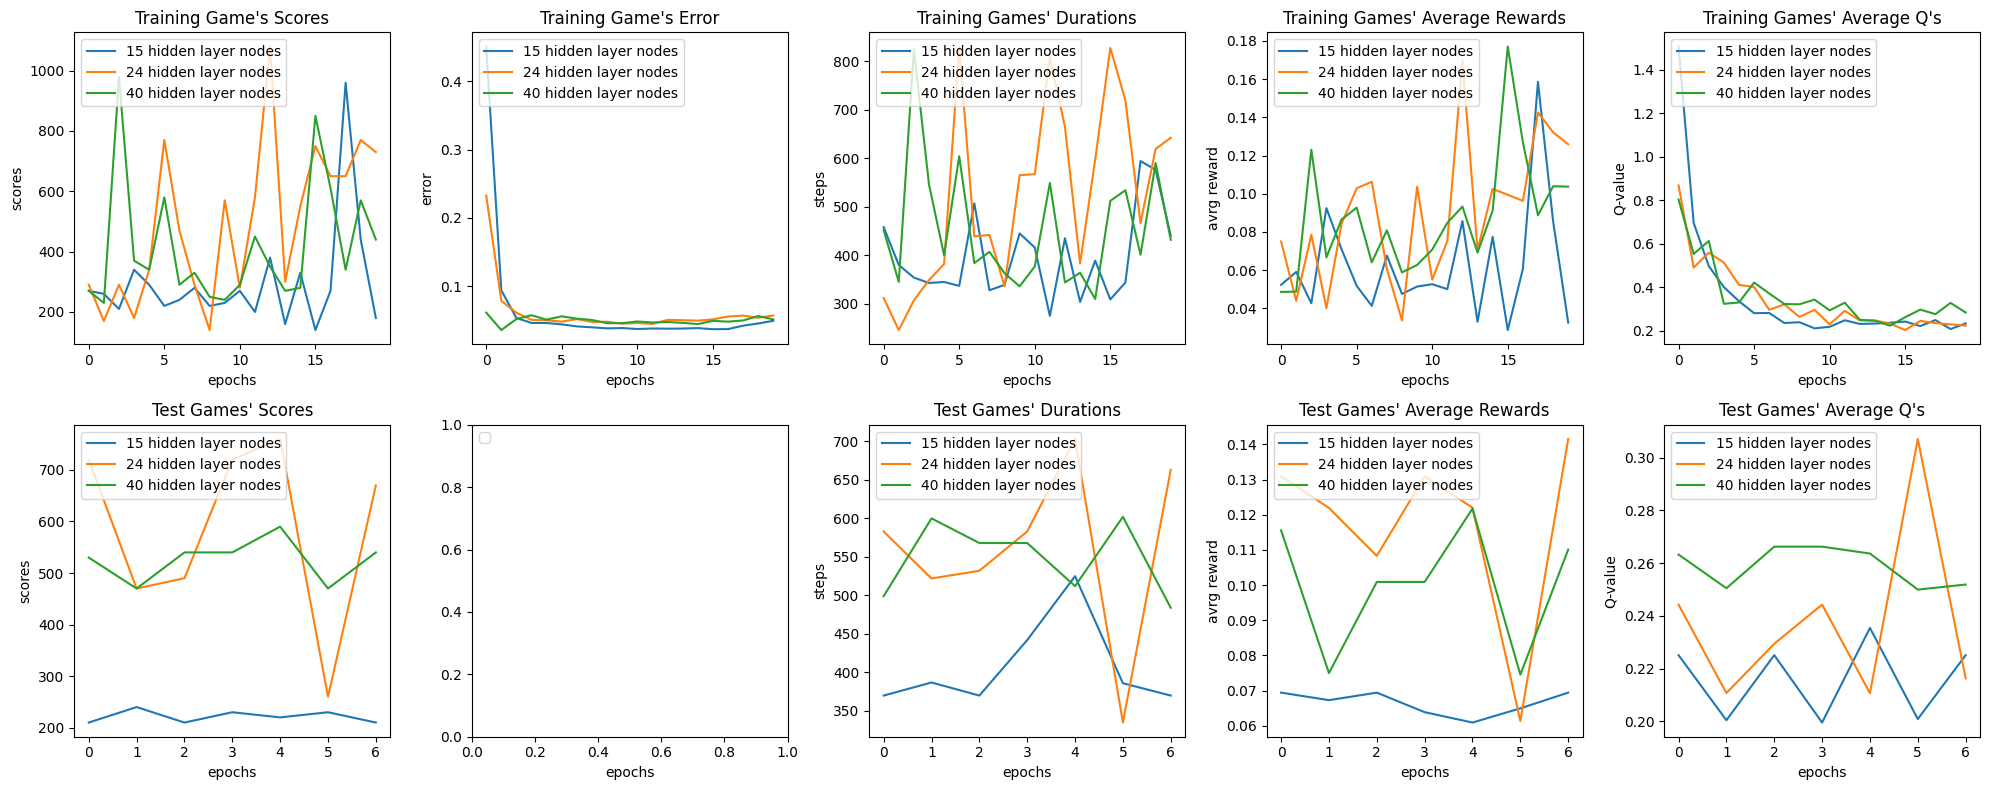

 Best number of nodes was : 24


In [ ]:
# test different hidden layer nodes values
Nnodes = [15, 24, 40]

# initalize new games
names = []
for n in Nnodes:
    names.append(str(n)+ " hidden layer nodes")

# train and evaluate
trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(Nnodes=Nnodes, Nepochs=Nepochs, QNet=Qnet_Best)

# plot
plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=names)

# select best
# average test scores
testScores = [sum(score)/len(score) for score in testScores]
Nnodes_Best = Nnodes[np.argmax(testScores)]
print(" Best number of nodes was : "+ str(Nnodes_Best))

Determing if we should give awards based on how far from the ghosts the pacman is, or just based on eating the coins

Testing 2 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_3HL'> with 24 nodes, with policy net 135054879238800 , and 135054885566416. lr = 0.0001, gamma = 0.5, tau = 0.01. Action = <bound method MsPacmanGame.select_action_Greedy of <qNetArchitecture.MsPacmanGame object at 0x7ad4f5399e90>>. Memory address for model is 135054878405264
episode:  0
Complete with score:  140.0
episode:  1
Complete with score:  460.0
episode:  2
Complete with score:  200.0
episode:  3
Complete with score:  310.0
episode:  4
Complete with score:  180.0
episode:  5
Complete with score:  430.0
episode:  6
Complete with score:  240.0
episode:  7
Complete with score:  200.0
episode:  8
Complete with score:  970.0
episode:  9
Complete with score:  260.0
episode:  10
Complete with score:  190.0
episode:  11
Complete with score:  300.0
episode:  12
Complete with score:  210.0
episode:  13
Complete with score:  330.0
episode:  14
Complete with score:  270.0
episode:  15
Complete with score:  1070

<ipython-input-24-a998bc29578d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=2)


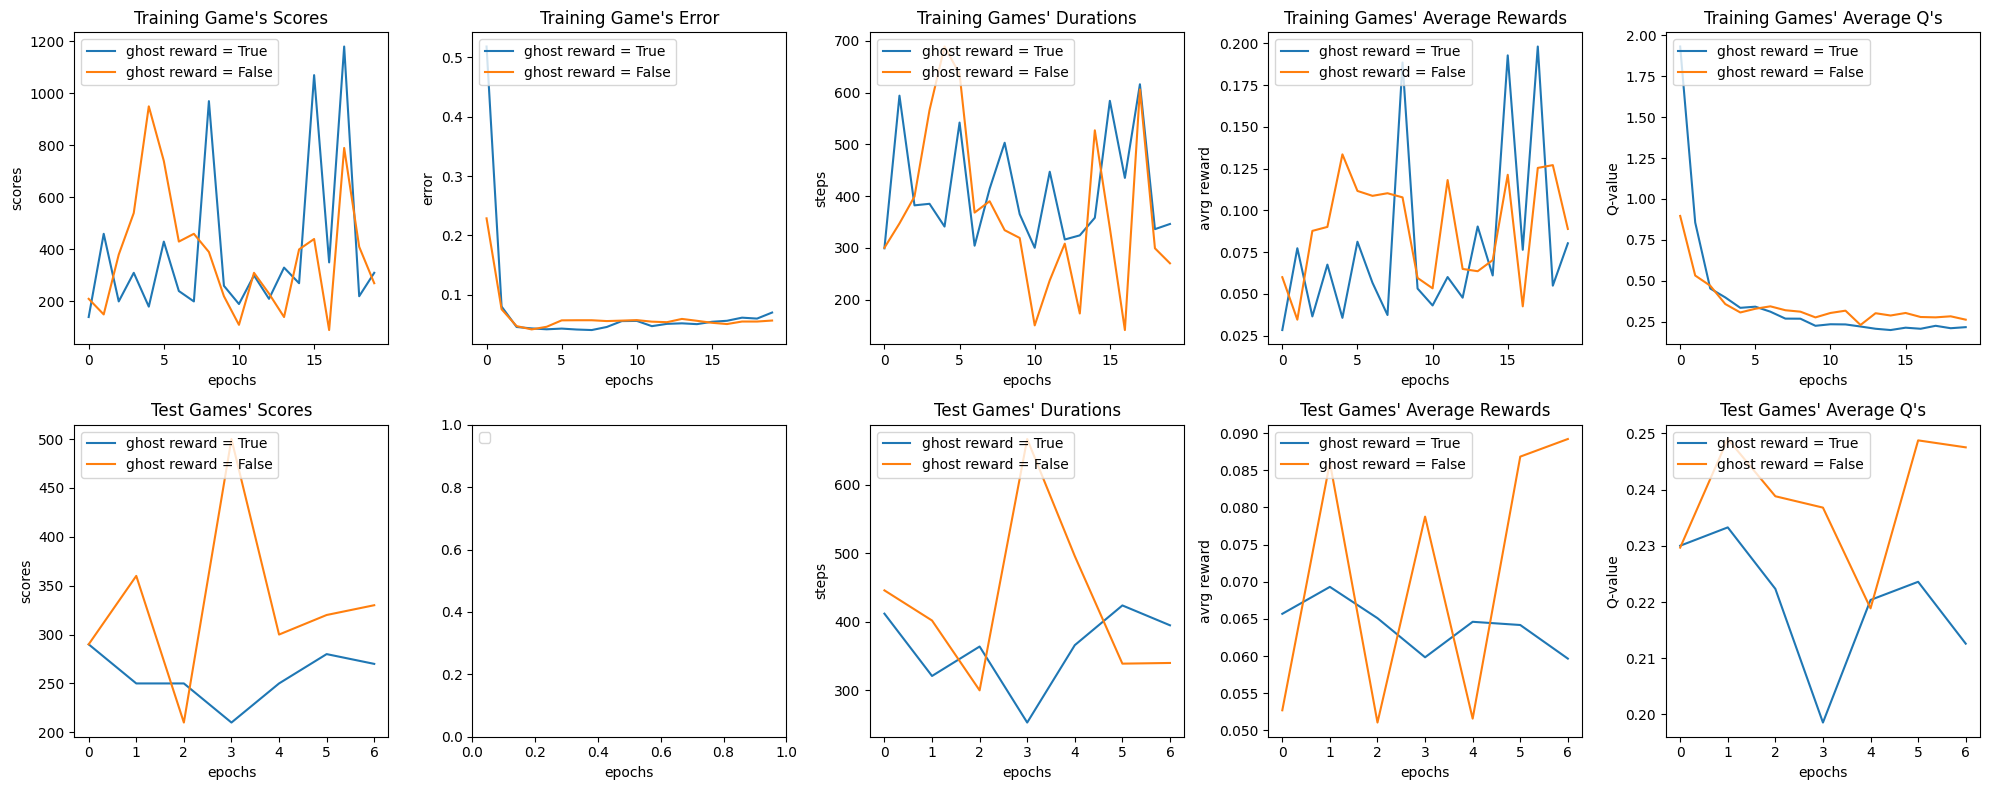

 Best reward was : False


In [ ]:

ghostReward = [True, False]

# initalize new games
names = []
for n in ghostReward:
    names.append("ghost reward = " + str(n))

# train and evaluate
trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(ghostReward = ghostReward,\
                                                                                                                Nnodes = Nnodes_Best, QNet = Qnet_Best, Nepochs = Nepochs)

# plot
plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=names)

# select best
# average test scores
testScores = [sum(score)/len(score) for score in testScores]
reward_Best = ghostReward[np.argmax(testScores)]
print(" Best reward was : "+ str(reward_Best))

## Exploration Strategies in Reinforcement Learning

When training an agent to navigate states through actions, early-selected actions can have disproportionately high Q-values. This can cause the agent to overcommit to those actions, failing to explore alternatives that might yield better rewards. To mitigate this, two exploration algorithms were implemented: **epsilon-greedy** and **upper confidence bound (UCB) exploration**.

### **Epsilon-Greedy Exploration**
Epsilon-greedy modifies action selection by choosing the action that maximizes $Q(s, a)$ with probability $1 - \epsilon$, and selecting a random action with probability $\epsilon$. The value of $\epsilon$ follows an exponential decay, ensuring more frequent exploration at the start of training.

### **Upper Confidence Bound (UCB) Exploration**
UCB exploration tracks how often each action has been chosen and adds an exploration bonus to the Q-values based on the formula:


$Q(s, a) + C \sqrt{\frac{\log(N_{\text{all actions}})}{N_{\text{action}}}}$


This encourages the agent to explore actions that have been selected less frequently.

Below, we evaluate both exploration methods.


In [ ]:
Qnet_Best = DQN_3HL
Nnodes_Best = 24
reward_Best = False

Testing 2 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_3HL'> with 24 nodes, with policy net 135054879546512 , and 135054885761808. lr = 0.0001, gamma = 0.5, tau = 0.01. Action = <bound method MsPacmanGame.select_action_UCB of <qNetArchitecture.MsPacmanGame object at 0x7ad4ea1ed950>>. Memory address for model is 135054843643088
episode:  0


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Complete with score:  100.0
episode:  1
Complete with score:  150.0
episode:  2
Complete with score:  200.0
episode:  3
Complete with score:  200.0
episode:  4
Complete with score:  620.0
episode:  5
Complete with score:  80.0
episode:  6
Complete with score:  830.0
episode:  7
Complete with score:  70.0
episode:  8
Complete with score:  140.0
episode:  9
Complete with score:  450.0
episode:  10
Complete with score:  540.0
episode:  11
Complete with score:  330.0
episode:  12
Complete with score:  500.0
episode:  13
Complete with score:  270.0
episode:  14
Complete with score:  960.0
episode:  15
Complete with score:  210.0
episode:  16
Complete with score:  280.0
episode:  17
Complete with score:  520.0
episode:  18
Complete with score:  720.0
episode:  19
Complete with score:  740.0
max action picked = 6422, random action picked = 2866
Game ended with score:  320.0
Game ended with score:  320.0
Game ended with score:  700.0
Game ended with score:  110.0
Game ended with score:  210.0


<ipython-input-24-a998bc29578d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=2)


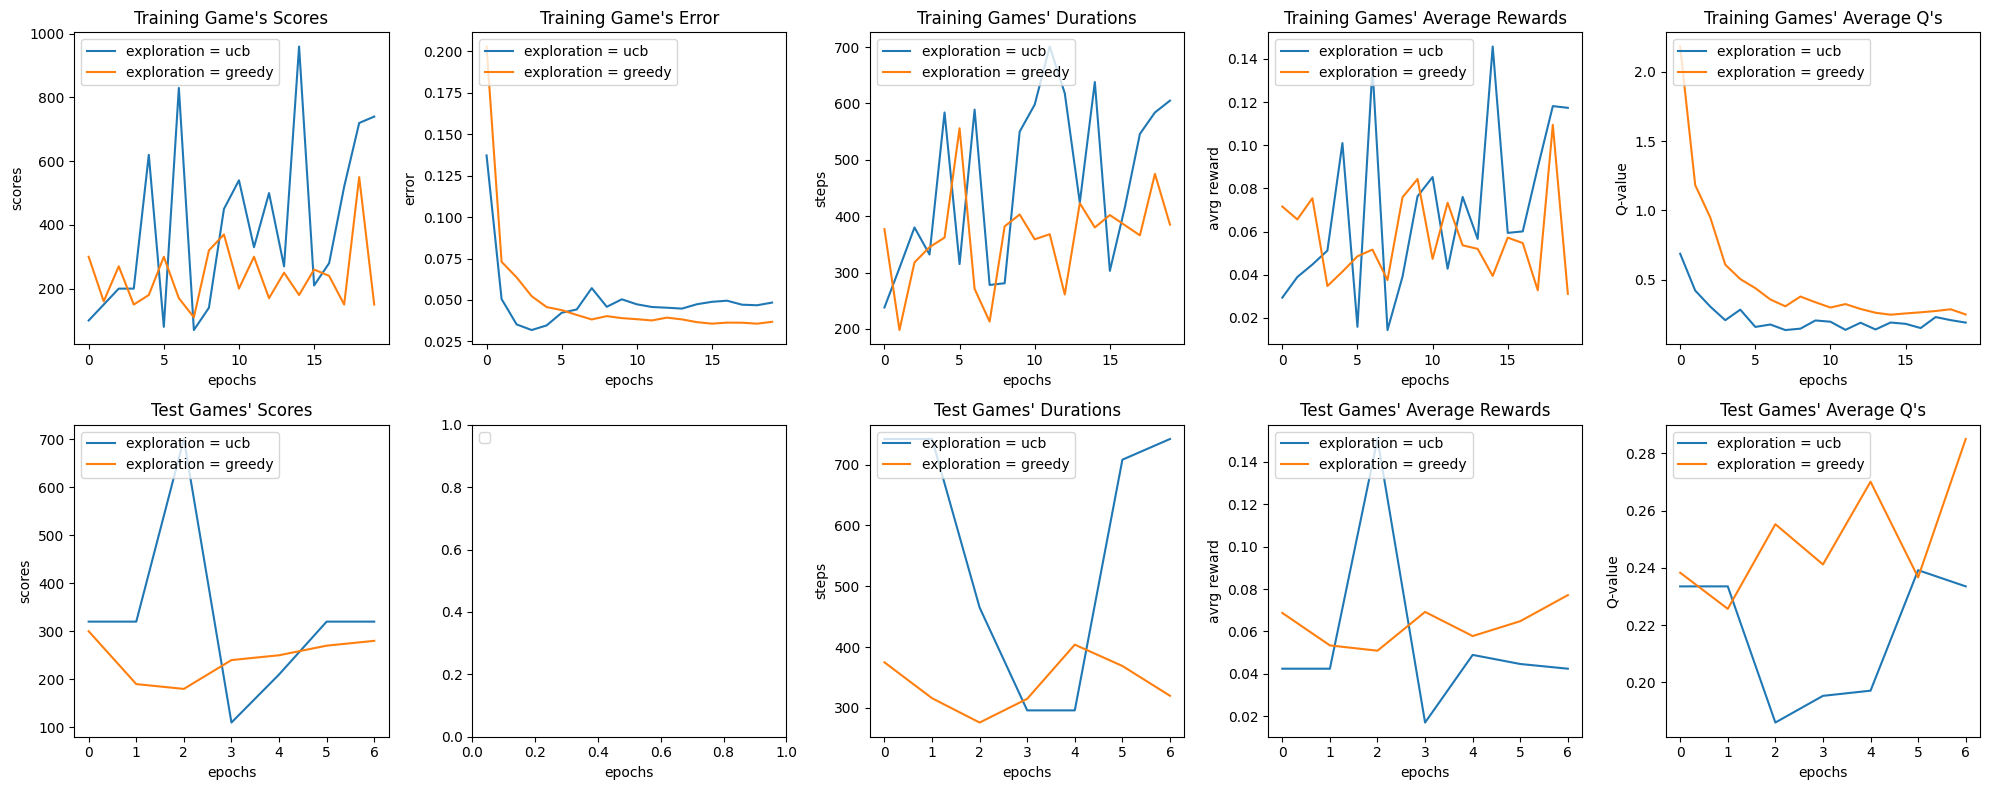

 Best exploration was : ucb


In [ ]:
# testing
exploration = ["ucb", "greedy"]

# initalize new games
names = []
for n in exploration:
    names.append("exploration = " + str(n))

# train and evaluate
trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(explore = exploration,\
                                                                                                                ghostReward=reward_Best, Nnodes = Nnodes_Best, QNet = Qnet_Best, Nepochs = Nepochs)

# plot
plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=names)

# select best
# average test scores
testScores = [sum(score)/len(score) for score in testScores]
explore_Best = exploration[np.argmax(testScores)]
print(" Best exploration was : "+ str(explore_Best))

Finding Best Learning Rate

Testing 4 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_3HL'> with 24 nodes, with policy net 135054884611984 , and 135054843773456. lr = 1e-06, gamma = 0.5, tau = 0.01. Action = <bound method MsPacmanGame.select_action_UCB of <qNetArchitecture.MsPacmanGame object at 0x7ad4ea1dcad0>>. Memory address for model is 135054879703888
episode:  0
Complete with score:  1940.0
episode:  1
Complete with score:  130.0
episode:  2
Complete with score:  410.0
episode:  3
Complete with score:  350.0
episode:  4
Complete with score:  360.0
episode:  5
Complete with score:  140.0
episode:  6
Complete with score:  490.0
episode:  7
Complete with score:  350.0
episode:  8
Complete with score:  210.0
episode:  9
Complete with score:  370.0
episode:  10
Complete with score:  560.0
episode:  11
Complete with score:  300.0
episode:  12
Complete with score:  140.0
episode:  13
Complete with score:  230.0
episode:  14
Complete with score:  190.0
episode:  15
Complete with score:  370.0
e

<ipython-input-24-a998bc29578d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=2)


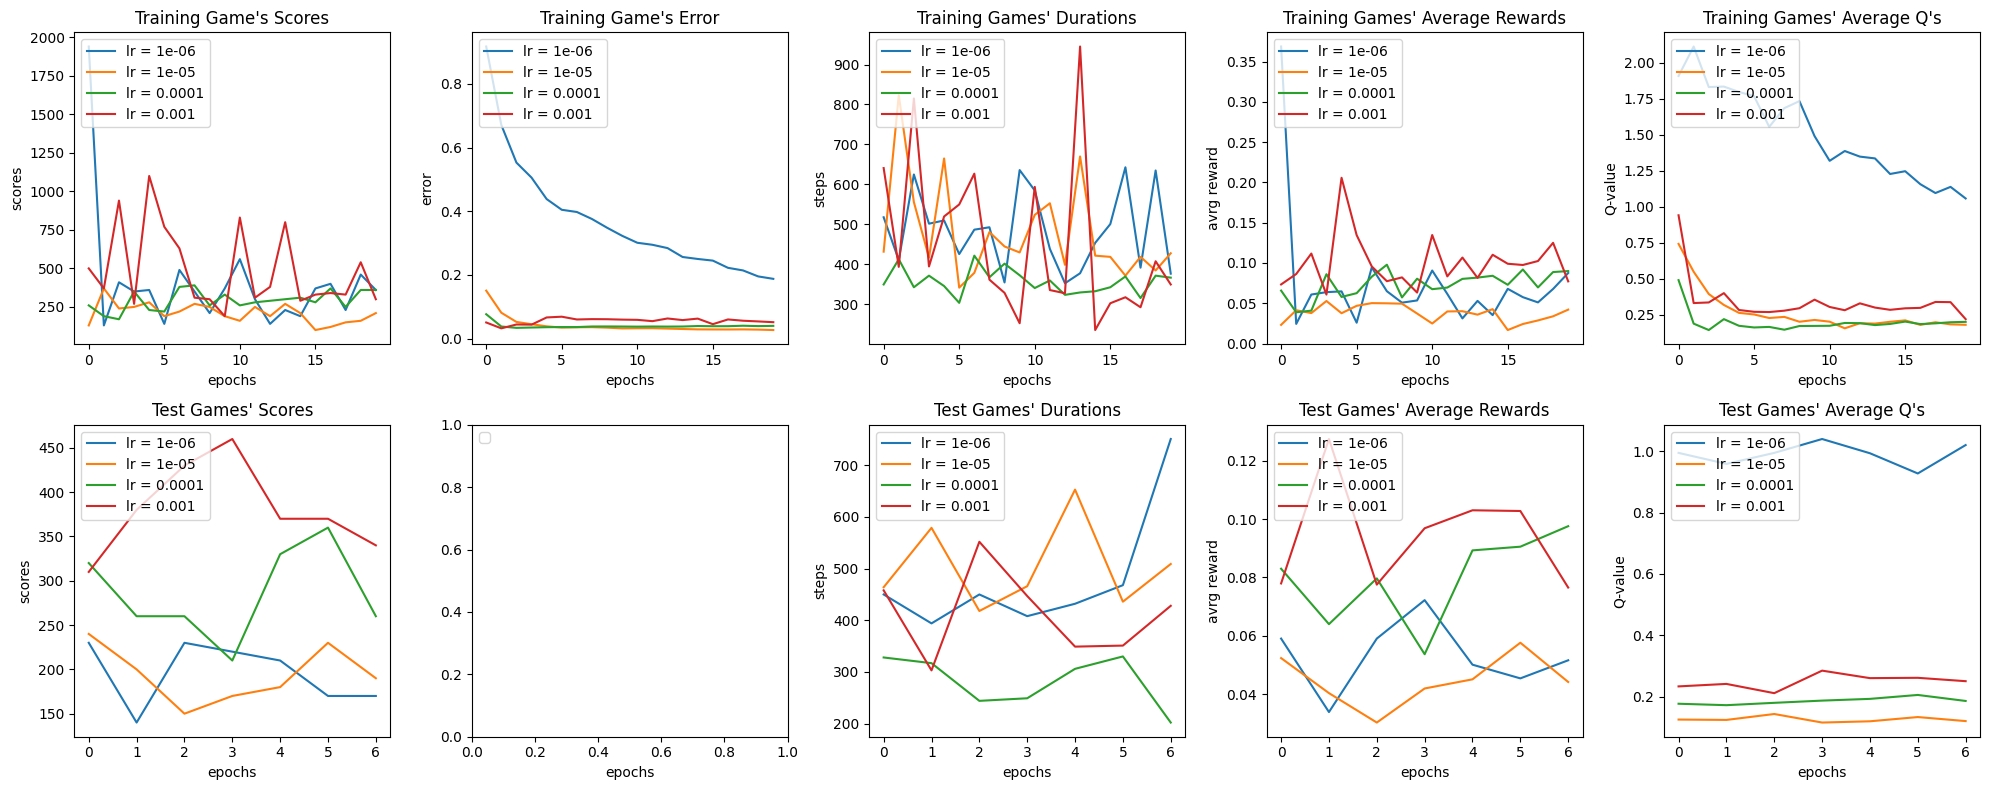

 Best learning rate was : 0.001


In [ ]:
# testing lr
lrAll = [0.000001, 0.00001, 0.0001, 0.001]

# initalize new games
names = []
for n in lrAll:
    names.append("lr = " + str(n))

# train and evaluate
trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(lr = lrAll,\
                                                                                                                explore = explore_Best, ghostReward=reward_Best, Nnodes = Nnodes_Best, QNet = Qnet_Best, Nepochs = Nepochs)

# plot
plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=names)

# select best
# average test scores
testScores = [sum(score)/len(score) for score in testScores]
lr_Best = lrAll[np.argmax(testScores)]
print(" Best learning rate was : "+ str(lr_Best))

Determine best Gamma (how much to weight future Q values) in $error = Q(s_t, a) - [\gamma * max(Q(s_{t+1})) + R ]$
<br>
Small gamma values cause Q-net to focus on the current position and disregard future states, while large gamma emphasize future positions.

Testing 3 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_3HL'> with 24 nodes, with policy net 135054835499920 , and 135058182032656. lr = 0.001, gamma = 0.5, tau = 0.01. Action = <bound method MsPacmanGame.select_action_UCB of <qNetArchitecture.MsPacmanGame object at 0x7ad4eb1b3450>>. Memory address for model is 135054881426896
episode:  0
Complete with score:  220.0
episode:  1
Complete with score:  260.0
episode:  2
Complete with score:  290.0
episode:  3
Complete with score:  1290.0
episode:  4
Complete with score:  250.0
episode:  5
Complete with score:  330.0
episode:  6
Complete with score:  350.0
episode:  7
Complete with score:  280.0
episode:  8
Complete with score:  250.0
episode:  9
Complete with score:  650.0
episode:  10
Complete with score:  200.0
episode:  11
Complete with score:  1980.0
episode:  12
Complete with score:  500.0
episode:  13
Complete with score:  290.0
episode:  14
Complete with score:  1680.0
episode:  15
Complete with score:  460.0

<ipython-input-24-a998bc29578d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=2)


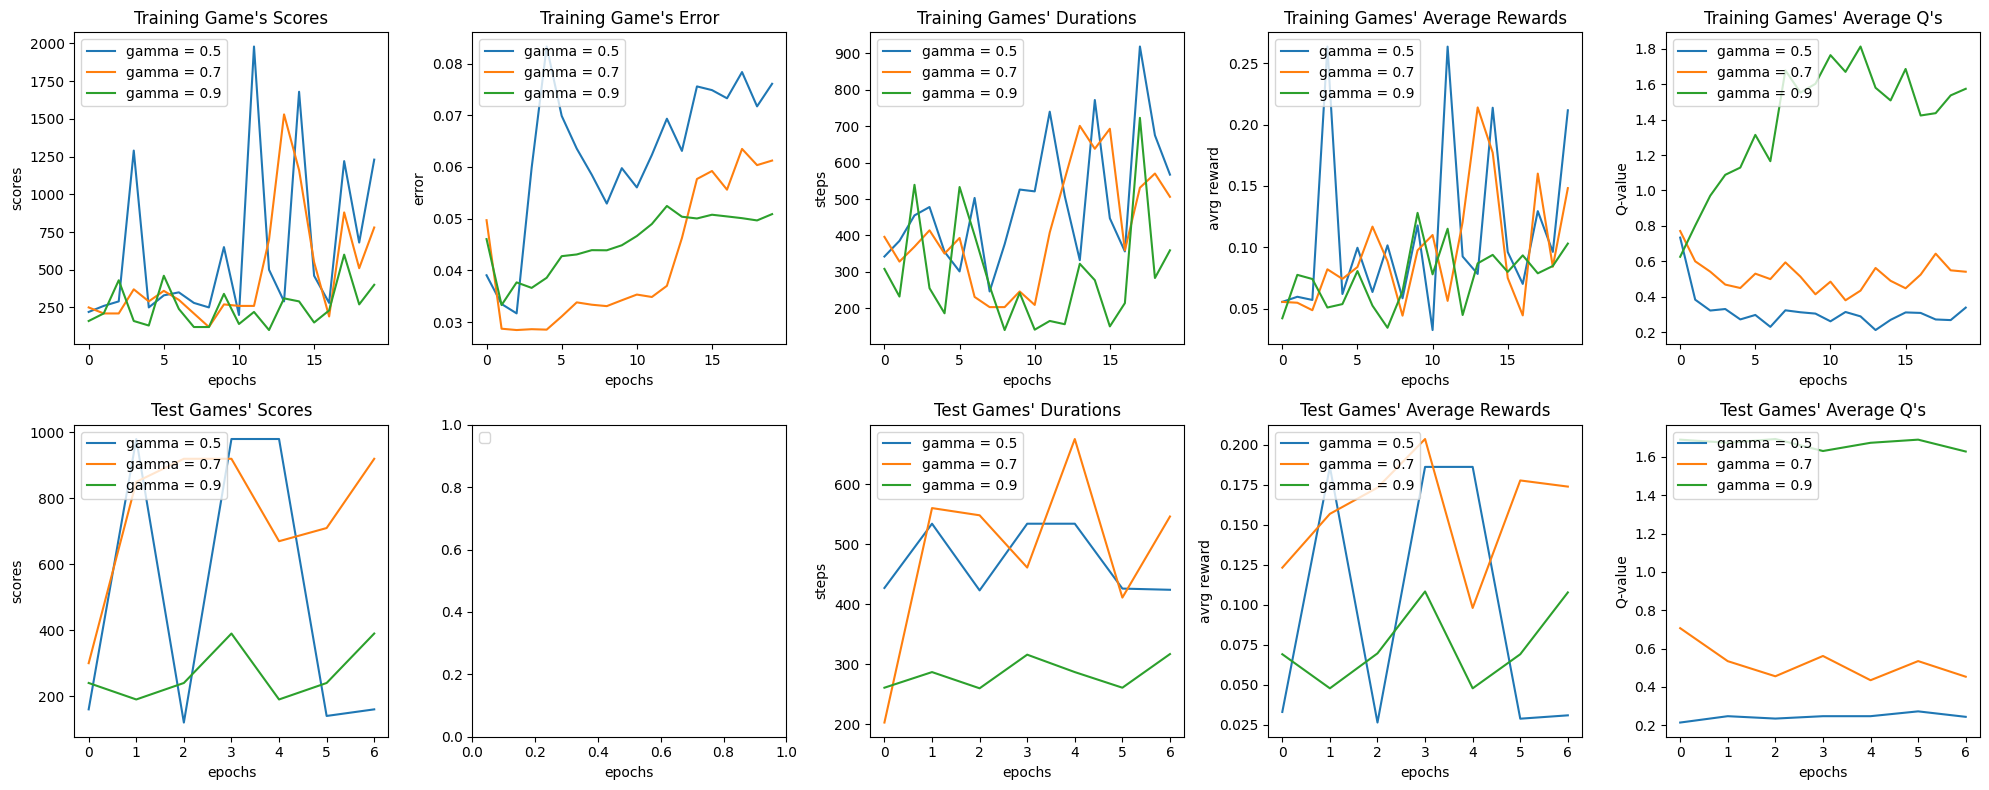

 Best gamma was : 0.7


In [ ]:
gammaAll = [0.5, 0.7, 0.9]

# initalize new games
names = []
for n in gammaAll:
    names.append("gamma = " + str(n))

# train and evaluate
trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(gamma = gammaAll,\
                                                                                                                lr = lr_Best, explore = explore_Best, ghostReward=reward_Best, Nnodes = Nnodes_Best, QNet = Qnet_Best, Nepochs = Nepochs)

# plot
plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=names)

# select best
# average test scores
testScores = [sum(score)/len(score) for score in testScores]
gamma_Best = gammaAll[np.argmax(testScores)]
print(" Best gamma was : "+ str(gamma_Best))

Best Tau (the amount the neural net values are passed to the network which evaluates future Q states)
To prevent large error propagations, the Q-net used to evaluate the future state's Q values in the error term are much more
slowly updated. <br>The update is $w_{Qnet′} ← \tau  w_{Qnet} + (1 − \tau ) w_{Q-net′}$

Testing 4 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_3HL'> with 24 nodes, with policy net 132347584214800 , and 132347581491792. lr = 0.001, gamma = 0.7, tau = 0.01. Action = <bound method MsPacmanGame.select_action_UCB of <qNetArchitecture.MsPacmanGame object at 0x785e91d99cd0>>. Memory address for model is 132344283561616
episode:  0


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Complete with score:  240.0
episode:  1
Complete with score:  200.0
episode:  2
Complete with score:  400.0
episode:  3
Complete with score:  660.0
episode:  4
Complete with score:  420.0
episode:  5
Complete with score:  350.0
episode:  6
Complete with score:  230.0
episode:  7
Complete with score:  320.0
episode:  8
Complete with score:  270.0
episode:  9
Complete with score:  520.0
episode:  10
Complete with score:  260.0
episode:  11
Complete with score:  440.0
episode:  12
Complete with score:  510.0
episode:  13
Complete with score:  640.0
episode:  14
Complete with score:  400.0
episode:  15
Complete with score:  470.0
episode:  16
Complete with score:  430.0
episode:  17
Complete with score:  470.0
episode:  18
Complete with score:  370.0
episode:  19
Complete with score:  420.0
max action picked = 6550, random action picked = 1807
Game ended with score:  230.0
Game ended with score:  290.0
Game ended with score:  210.0
Game ended with score:  230.0
Game ended with score:  230.

<ipython-input-8-a998bc29578d>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=2)


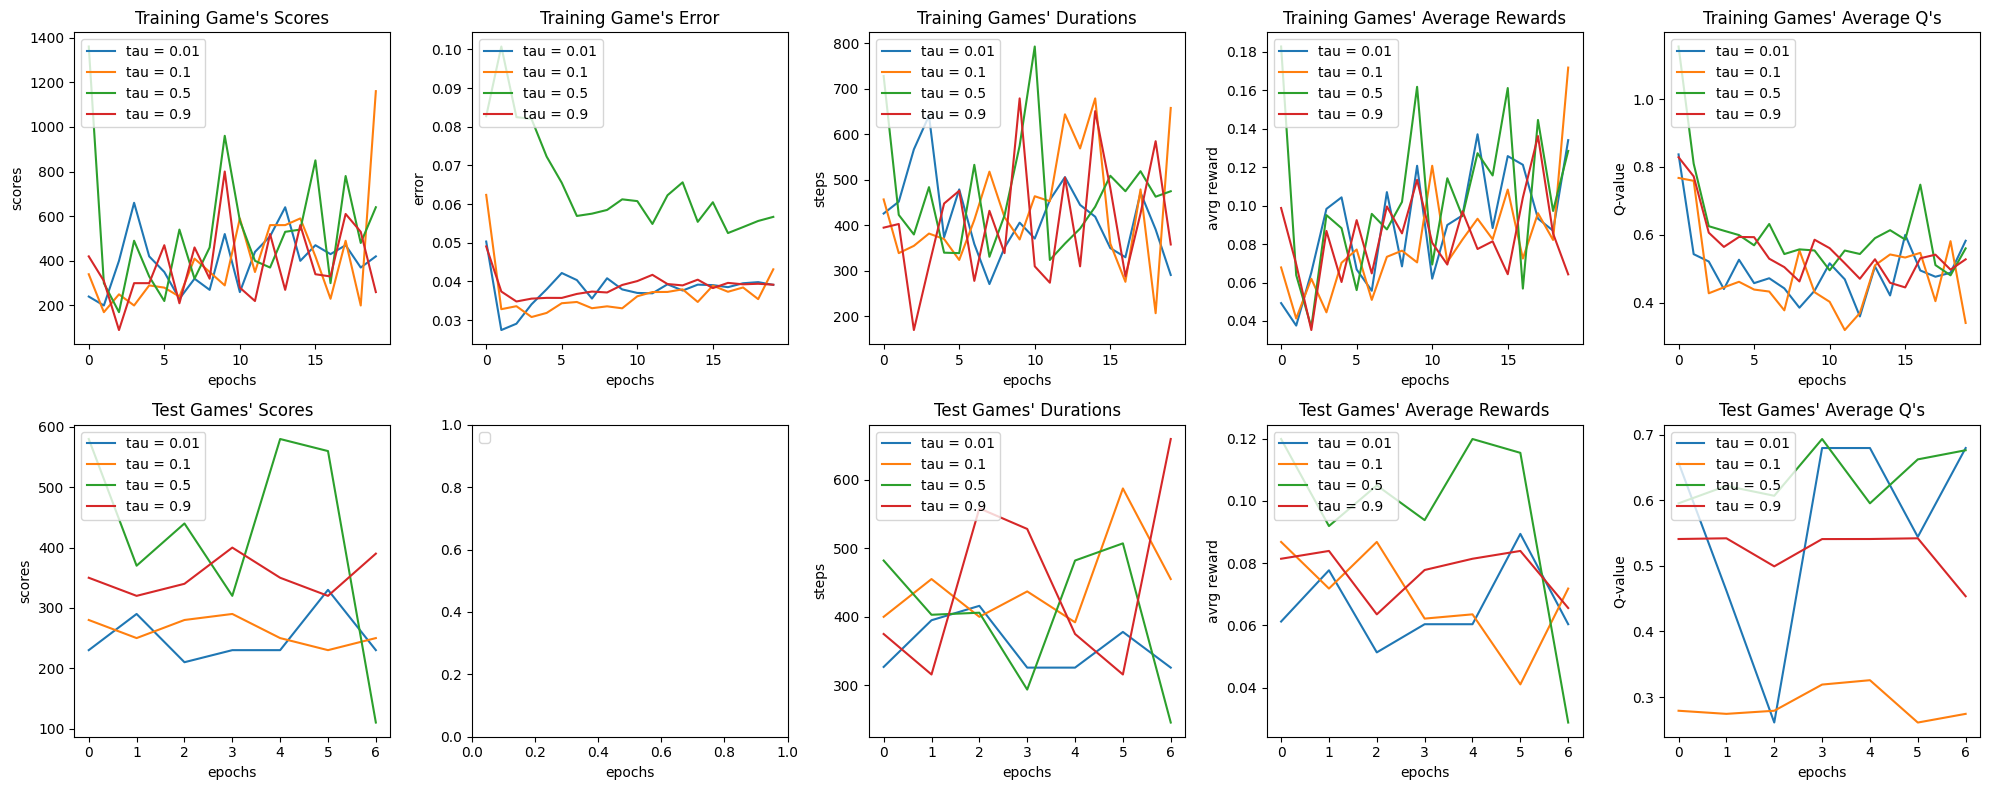

 Best tau was : 0.5


In [10]:
tauAll = [0.01, 0.1, 0.5, 0.9]

# initalize new games
names = []
for n in tauAll:
    names.append("tau = " + str(n))

# train and evaluate
trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(tau = tauAll,\
                                                                                                                gamma = gamma_Best, lr = lr_Best, explore = explore_Best, ghostReward=reward_Best, Nnodes = Nnodes_Best, QNet = Qnet_Best, Nepochs = Nepochs)

# plot
plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs, labels=names)

# select best
# average test scores
testScores = [sum(score)/len(score) for score in testScores]
tau_Best = tauAll[np.argmax(testScores)]
print(" Best tau was : "+ str(tau_Best))

## Part 2) Training the optimal version of the Q-net for many epochs
Q-Net with the best learning rate, tau and gamma will be trained for 200 epochs

In [11]:
Nepochs = 200

In [12]:
print("Optimial model will be trained " + str(Nepochs) + " epochs, with a " + str(Qnet_Best) + " Q-net, " + str(Nnodes_Best) + " nodes in each hidden layer, a lr = "\
       + str(lr_Best) + ", gamma = " + str(gamma_Best) + ", and tau = " + str(tau_Best))

Optimial model will be trained 200 epochs, with a <class 'qNetArchitecture.DQN_3HL'> Q-net, 24 nodes in each hidden layer, a lr = 0.001, gamma = 0.7, and tau = 0.5


In [9]:
Qnet_Best = DQN_3HL
Nnodes_Best = 24
reward_Best = False
explore_Best = "ucb"
lr_Best = 0.001
gamma_Best = 0.7
tau_Best = 0.5

Selecting hyperparameters based on increasing Q values along training and testing epochs, since we expect the max Q value to increase with training.

In [ ]:
print("Optimial model will be trained " + str(Nepochs) + " epochs, with a " + str(Qnet_Best) + " Q-net, " + str(Nnodes_Best) + " nodes in each hidden layer, a lr = "\
       + str(lr_Best) + ", gamma = " + str(gamma_Best) + ", and tau = " + str(tau_Best))

Testing 1 models
eps_end is 0.1
training...
Using <class 'qNetArchitecture.DQN_3HL'> with 24 nodes, with policy net 132344247112592 , and 132344203142096. lr = 0.001, gamma = 0.7, tau = 0.5. Action = <bound method MsPacmanGame.select_action_UCB of <qNetArchitecture.MsPacmanGame object at 0x785dcb603bd0>>. Memory address for model is 132344277748048
episode:  0
Complete with score:  180.0
episode:  1
Complete with score:  270.0
episode:  2
Complete with score:  210.0
episode:  3
Complete with score:  280.0
episode:  4
Complete with score:  740.0
episode:  5
Complete with score:  730.0
episode:  6
Complete with score:  310.0
episode:  7
Complete with score:  260.0
episode:  8
Complete with score:  820.0
episode:  9
Complete with score:  700.0
episode:  10
Complete with score:  240.0
episode:  11
Complete with score:  440.0
episode:  12
Complete with score:  760.0
episode:  13
Complete with score:  250.0
episode:  14
Complete with score:  680.0
episode:  15
Complete with score:  440.0
epi

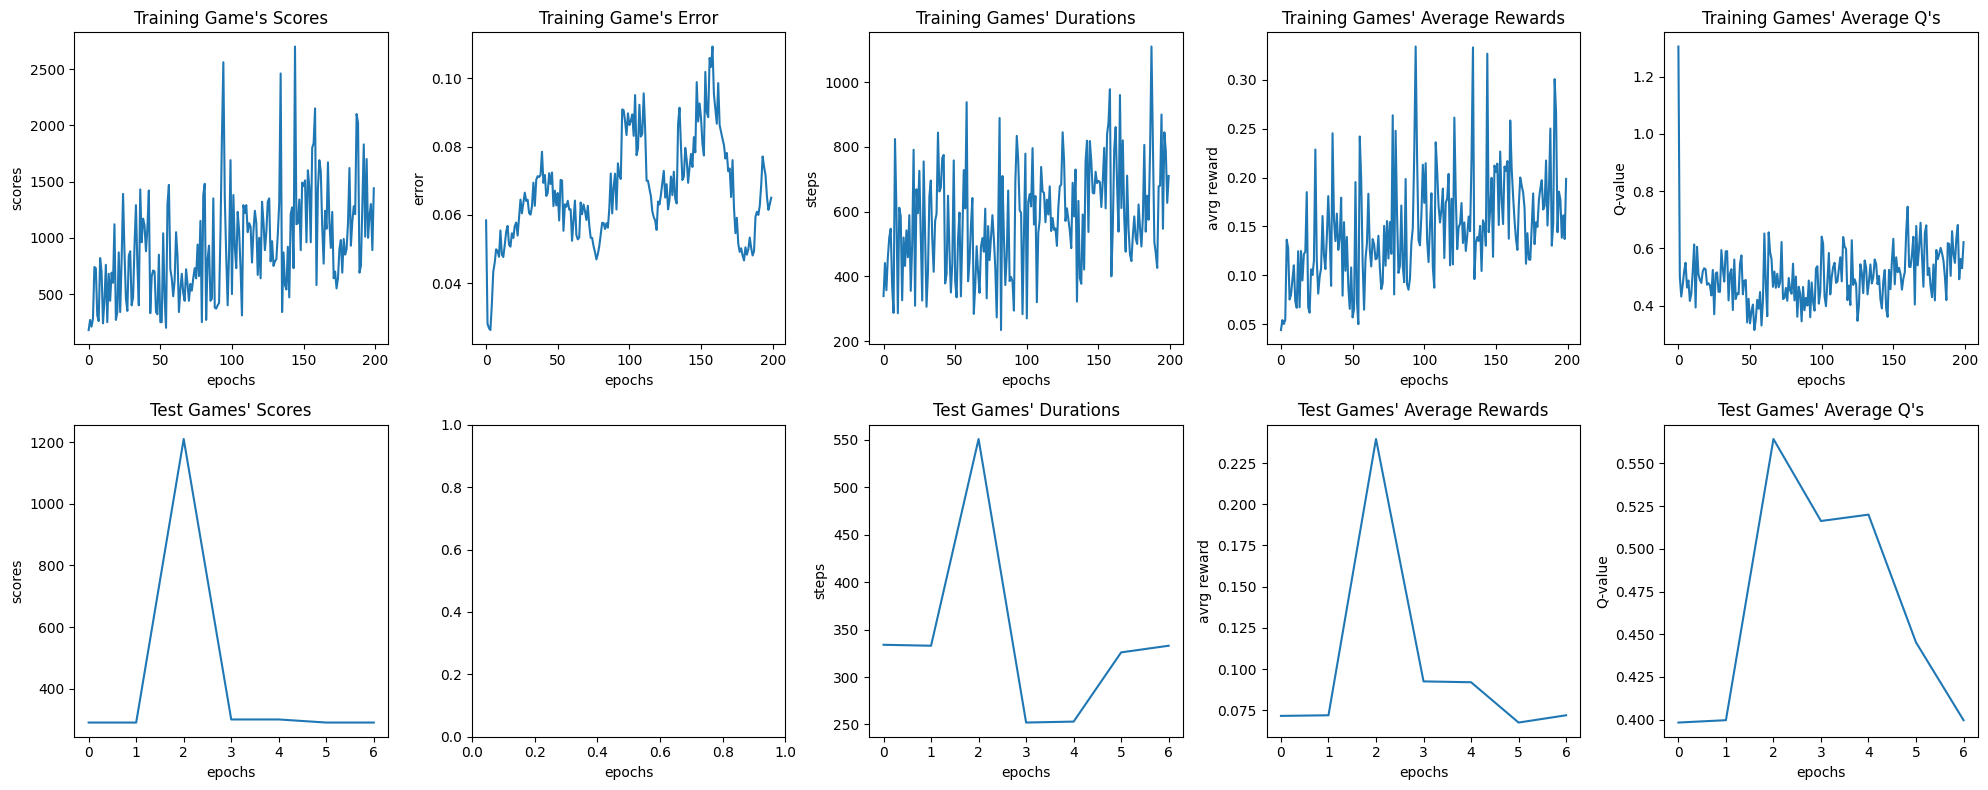

 Average Test score for the Optimized Q-Net is : 424.2857142857143


In [13]:
# initalize new games
names = ["Best_QNET"]

# train and evaluate
trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs = testModels(tau = tau_Best, gamma = gamma_Best, lr = lr_Best,\
                                                                                                                explore = explore_Best, ghostReward=reward_Best, \
                                                                                                                Nnodes = Nnodes_Best, QNet = Qnet_Best, Nepochs = Nepochs, ucb = 6, \
                                                                                                                 save=True, name=names)

# plot
plotEvalMetrics(trainScores, trainErrors, trainDur, trainRewards, trainQs, testScores, testDur, testRewards, testQs)

# select best
# average test scores
avrgScore = [sum(score)/len(score) for score in testScores][0]
print(" Average Test score for the Optimized Q-Net is : "+ str(avrgScore))

**The Q-net after optimization and training consistantly produces scores >1000**
<br>  During training (top row):
- Game scores (1st column) shows a extremely noisey increase during training examples,
- Training error (2nd column) shows error increase, possibly due to Q-values getting larger during training, leading to large errors. This is in contrast to small errors in early training epochs since Q-values are initalized to large values. Since error does not decrease significantly towards the end, more training epochs are necessary.
- Game durations (3rd column) are noisey and don't show clear increases
- Average reward (4th column) during training show an increase during training, along with a lot of noise
- Average max Q-values (5th column) show clear increase as Q-net learns the Q of more states and actions